# Recurrent Neural Networks: A Case study in well logs and LSTM's

All the models we have discussed so far were looking at the inputs as isolated instances. But there are many cases were datapoints are not isolated instances and have connection to each other. *Sequential data* are the type of data where each instance is related to the instances came before. 

A good example for this type of data is time series data. At each point in time to the value of the time series depends on the value of the prior points. Another example is depth data, like well logs.

Recurrent Neural Networks (RNN) are a class of networks which deal with sequential data. There are many variants of Recurrent Neural Networks, including:

- Simple Recurrect Neural Networks (Simple RNN - or often just called RNN)
- Gated Recurrent Unit (GRU)
- **Long Short-Term Memory (LSTM)**

In this notebook we will discuss LSTM; however, the general logic behind all these methods are the same. They only differ in the way they handle information internally. 


RNN's have been used for
- translation
- drawing chinese charectors
- composing music
- timeseries
- depth
- weather
- many more

## A minute of Theory

This is a hand on course, not theory so we will look at a high level view of one type of RNN, the LSTM. But lets look at the theory for a moment, to get some broad idea of how they work


The figure below is from d2l.ai and shows how an RNN can operate on a text sequence to predict the next charector.

![](images/rnn-train.svg)



How does the model itself work? Let look at an excerpt from the open source machine learning book [d2l.ai](d2l.ai):

![](images/rnn.svg)

> The figure below illustrates the computational logic of an RNN at three adjacent time steps. At any time step `t`, the computation of the hidden state can be treated as: 

> i) concatenating the input `Xt` at the current time step `t` and the hidden state `Ht−1` at the previous time step  `t−1` ; 

> ii) feeding the concatenation result into a fully-connected layer with the activation function `ϕ`. 

> The output of such a fully-connected layer is the hidden state  `Ht`  of the current time step  t . In this case, the model parameters are the concatenation of  `Wxh`  and  `Whh` , and a bias of  `bh`. The hidden state of the current time step  `t` , `Ht` , will participate in computing the hidden state  `Ht+1`  of the next time step  t+1 . What is more,  `Ht`  will also be fed into the fully-connected output layer to compute the output  `Ot`  of the current time step  `t` .

To understand more see these visualisations:

- [distill.pub memorization in rnns](memorization-in-rnns)
- [Chris Olah Understanding LSTMs](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

And see these chapters:

- [d2l.ai RNN's](http://d2l.ai/chapter_recurrent-neural-networks/rnn.html)
- [d2l.ai LSTM's](http://d2l.ai/chapter_recurrent-modern/lstm.html)


# Hands on example with well logs

You can read more [here](http://d2l.ai/chapter_recurrent-neural-networks/rnn.html), but lets dive into a hand on example first and it will begin to make more sense. We will be focusing on

- How do RNN's represent data
- How do we implement them in pytorch
- What are the key parameters and example values
- Where might you use them

In [1]:
import torch
from torch import nn, optim
from torch import functional as F
from torch.autograd import Variable
import torch
import torch.utils.data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import xarray as xr

# Models

## Low level

[LSTMCell docs](https://pytorch.org/docs/stable/generated/torch.nn.LSTMCell.html)

Lets look at a low level implementation, and compare it to the figure we previously saw

![](images/rnn.svg)

In [2]:
from sklearn.preprocessing import LabelEncoder

# Our input text
text = list("""Machine Learning. Deep""")
e = LabelEncoder()
input = e.fit_transform(text)
input

array([ 4,  5,  6,  9, 10, 11,  7,  0,  3,  7,  5, 13, 11, 10, 11,  8,  1,
        0,  2,  7,  7, 12])

In [3]:
# Visualize it
pd.DataFrame(list(zip(text, input)), columns=['char', 'int']).T

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
char,M,a,c,h,i,n,e,,L,e,...,n,i,n,g,.,,D,e,e,p
int,4,5,6,9,10,11,7,0,3,7,...,11,10,11,8,1,0,2,7,7,12


In [4]:
# We can use the low level LSTM Cell
rnn = nn.LSTMCell(input_size=1, hidden_size=20)

# Input [Sequence Length=6, BatchSize=1, input_size=1]
input = torch.from_numpy(input)[:, None, None].float()

# Initial states (Batch size, Hidden Size)
hx = torch.randn(1, 20) # Initial hidden
cx = torch.randn(1, 20) # Initial cell

output = []
# we manually call it on each part of the sequence
for i in range(6):
    # We manually handle states
    hx, cx = rnn(input[i], (hx, cx))
    output.append(hx)
    
# Seqence, Batch, Hidden size
output = torch.stack(output)
output.shape

torch.Size([6, 1, 20])

In [5]:
# As always you can read more about an LSTMCell in the help or docs
help(nn.LSTMCell)

Help on class LSTMCell in module torch.nn.modules.rnn:

class LSTMCell(RNNCellBase)
 |  LSTMCell(input_size, hidden_size, bias=True)
 |  
 |  A long short-term memory (LSTM) cell.
 |  
 |  .. math::
 |  
 |      \begin{array}{ll}
 |      i = \sigma(W_{ii} x + b_{ii} + W_{hi} h + b_{hi}) \\
 |      f = \sigma(W_{if} x + b_{if} + W_{hf} h + b_{hf}) \\
 |      g = \tanh(W_{ig} x + b_{ig} + W_{hg} h + b_{hg}) \\
 |      o = \sigma(W_{io} x + b_{io} + W_{ho} h + b_{ho}) \\
 |      c' = f * c + i * g \\
 |      h' = o * \tanh(c') \\
 |      \end{array}
 |  
 |  where :math:`\sigma` is the sigmoid function, and :math:`*` is the Hadamard product.
 |  
 |  Args:
 |      input_size: The number of expected features in the input `x`
 |      hidden_size: The number of features in the hidden state `h`
 |      bias: If ``False``, then the layer does not use bias weights `b_ih` and
 |          `b_hh`. Default: ``True``
 |  
 |  Inputs: input, (h_0, c_0)
 |      - **input** of shape `(batch, input_size

## High level

Or we can use the high level API that handles it for you

[LSTMdocs](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)

In [6]:
help(nn.LSTM)

Help on class LSTM in module torch.nn.modules.rnn:

class LSTM(RNNBase)
 |  LSTM(*args, **kwargs)
 |  
 |  Applies a multi-layer long short-term memory (LSTM) RNN to an input
 |  sequence.
 |  
 |  
 |  For each element in the input sequence, each layer computes the following
 |  function:
 |  
 |  .. math::
 |      \begin{array}{ll} \\
 |          i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{(t-1)} + b_{hi}) \\
 |          f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{(t-1)} + b_{hf}) \\
 |          g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{(t-1)} + b_{hg}) \\
 |          o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{(t-1)} + b_{ho}) \\
 |          c_t = f_t * c_{(t-1)} + i_t * g_t \\
 |          h_t = o_t * \tanh(c_t) \\
 |      \end{array}
 |  
 |  where :math:`h_t` is the hidden state at time `t`, :math:`c_t` is the cell
 |  state at time `t`, :math:`x_t` is the input at time `t`, :math:`h_{(t-1)}`
 |  is the hidden state of the layer at time `t-1` or the initial hidden
 |  state a

In [7]:

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size=1):
        super(LSTM, self).__init__()
        # Params
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        # High level LSTM library, nn.LSTMCell is a lower level one
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
        )
        
        # Final layer
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        seq_len = x.shape[1]
        
        output, (_, _) = self.lstm(x)
        h = output.view(-1, seq_len, self.hidden_size)[:, -1]
        
        return self.linear(h)

## The well log classification problem 

In this scenario we are drilling downwards, and while well logs are reported instantly, there is a lag in facies of around 15 meter (see diagram), while they are interpreated by a petrophysicist. The problem is we would like to know the facies as soon as possible in order decide if, how, and where to drill.

Lets apply machine learning. There are many ways to set up this problem, and geology is especially hard due to the important of context and the amount of undigitized information (much of it is in the brain of old and grizzled geologists).

In this scenario we will apply an RNN. 
- It will travel down the well
- Input are 
    - the last 200 meters of well logs 
    - and the geologist facies interpreation up to 15 meters ago
- The label is the facies at the point in the well


You may ask: "Isn't it cheating? Because it knows the human labels from 15 meters above?" 

We measure this and it gives a ~60% accuracy. So this is the naive baseline that we have to beat.

<img src="images/diagram.png" width="600"/>



# Parameters

In [8]:
# Params
device = "cuda" if torch.cuda.is_available() else "cpu"
shift_length = 100
seq_length = 600
max_lithologies = 12
max_wells = 20


print(f'context length of {0.15*seq_length} m or {seq_length} intervals')
print(f'model can see human labels up to {shift_length*0.15}m above. Or {shift_length} intervals')

context length of 90.0 m or 600 intervals
model can see human labels up to 15.0m above. Or 100 intervals


## Data

In this example we are going to look at well logs which are sequential data as well.

In [9]:


import pandas as pd
import xarray as xr
xf = xr.open_zarr("../../data/processed/geolink_norge_dataset/geolink_norge_well_logs.zarr")

# We will use just the 30* wells
xf = xf.where(xf['Well'].str.startswith('30')).dropna(dim='Well', how='all')

df = xf.to_dataframe().swaplevel()
df['LITHOLOGY_GEOLINK'] = df['LITHOLOGY_GEOLINK'].astype('category')
df['Well'] = df.index.get_level_values(0).astype('category')
df['DEPT'] = df.index.get_level_values(1)

# Keep these cols
feature_cols = ['CALI', 'DTC', 'GR', 'RDEP', 'RHOB',
       'RMED', 'xc', 'yc', 'DEPT']
df = df.dropna(how='any', subset=feature_cols+['LITHOLOGY_GEOLINK'])
df = df.sort_index()
df

CALI      DRHO         DTC        Depth         GR  \
Well    DEPT                                                               
30_11-3 2118.70  12.435000  0.019995  109.432205  2118.744629  62.438549   
        2118.85  12.584001  0.017000  102.456642  2118.896973  61.501503   
        2119.00  12.606000  0.005989   95.108009  2119.049561  61.000000   
        2119.15  12.391000 -0.001005   99.642990  2119.201904  61.905998   
        2119.30  12.224000 -0.004000  108.136383  2119.354248  58.568348   
...                    ...       ...         ...          ...        ...   
30_7-7  5022.10   5.961000 -0.008000   81.231377  5022.173828  59.574780   
        5022.25   5.961000 -0.008000   81.231377  5022.173828  59.574780   
        5022.40   5.941000 -0.010000   81.126503  5022.326660  60.271767   
        5022.55   5.887000 -0.017000   80.289490  5022.479004  59.796532   
        5022.70   5.902000 -0.017000   78.824585  5022.631348  55.645344   

                LITHOLOGY_GEOLINK      NPHI      RDEP      RHOB   RMED  ...  \
Well    DEPT                                                            ...   
30_11-3 2118.70              Silt  0.331327  1.321802  2.305019  1.439  ...   
        2118.85              Silt  0.341750  1.478748  2.317000  1.439  ...   
        2119.00              Silt  0.335467  1.553000  2.327976  1.534  ...   
        2119.15              Silt  0.327281  1.512000  2.312981  1.777  ...   
        2119.30              Silt  0.327865  1.441114  2.300995  1.636  ...   
...                           ...       ...       ...       ...    ...  ...   
30_7-7  5022.10              Silt  0.181640  2.438013  2.455000  2.889  ...   
        5022.25              Silt  0.181640  2.438013  2.455000  2.889  ...   
        5022.40              Silt  0.176270  2.438000  2.463000  2.818  ...   
        5022.55              Silt  0.173340  2.461923  2.455000  2.796  ...   
        5022.70              Silt  0.175290  2.503865  2.465000  2.774  ...   

                         SP  split    wlbCompletionDate wlbCompletionYear  \
Well    DEPT                                                                
30_11-3 2118.70  112.250000  train  1983-03-14T00:00:00            1983.0   
        2118.85  113.250000  train  1983-03-14T00:00:00            1983.0   
        2119.00  112.750000  train  1983-03-14T00:00:00            1983.0   
        2119.15  114.250000  train  1983-03-14T00:00:00            1983.0   
        2119.30  114.000000  train  1983-03-14T00:00:00            1983.0   
...                     ...    ...                  ...               ...   
30_7-7  5022.10   25.291620  train  1979-01-07T00:00:00            1979.0   
        5022.25   25.291620  train  1979-01-07T00:00:00            1979.0   
        5022.40   25.783422  train  1979-01-07T00:00:00            1979.0   
        5022.55   25.979374  train  1979-01-07T00:00:00            1979.0   
        5022.70   25.505526  train  1979-01-07T00:00:00            1979.0   

                 wlbKellyBushElevation  wlbTotalDepth        xc         yc  \
Well    DEPT                                                                 
30_11-3 2118.70                   25.0         4662.0  2.537631  60.044053   
        2118.85                   25.0         4662.0  2.537631  60.044053   
        2119.00                   25.0         4662.0  2.537631  60.044053   
        2119.15                   25.0         4662.0  2.537631  60.044053   
        2119.30                   25.0         4662.0  2.537631  60.044053   
...                                ...            ...       ...        ...   
30_7-7  5022.10                   25.0         5127.0  2.268694  60.272028   
        5022.25                   25.0         5127.0  2.268694  60.272028   
        5022.40                   25.0         5127.0  2.268694  60.272028   
        5022.55                   25.0         5127.0  2.268694  60.272028   
        5022.70                   25.0         5127.0  2.268694  60


  <div class="alert alert-success">
  <h2>Exercise</h2>

  Discussion: Are there better ways we should set this up?
    
  What are the benefits?
    
  What information are we missing?
      

  <details>
  <summary><b>→ Hints</b></summary>

  There is no right answer except experimentation, but on creating this demo we found:
      
  * Generalising to a new well is hard, and it's important to have a similar distribution in test and train. So we took the top of some wells, and the bottom of others as training. 
  * Seeing the previous labels is important, as this encodes how the particular geologist interprets facies in this well. Which can often have some subjectivity
  * Long context help a lot, but also slow it down. We're using the last 200 meters, but seeing the whole well helps
  * Using all wells, instead of just the 30* wells will help it learn to generalise
  * Using all logs may help
  * We could do infilling instead
  * We could make it bi-directional
  * We could make it a sequence to sequence model, instead of sequence to 1
  * Transformer may do better
  * We could normalise the logs per window or well
  * Many more

  </details>

  </div>

## Data processing

In [10]:
# We  will stick to a group of long wells 29, 30, 31, 35 are valid groups
# df=df[df['Well'].str.startswith('30')]
counts = df['Well'].value_counts()
counts[counts>0]

30_2-1      15508
30_11-3     12978
30_6-11     12595
30_7-7      12016
30_6-8      10966
30_6-5      10883
30_3-2 R     8738
30_3-4 R     8692
30_4-2       6863
30_3-3       3942
30_6-23      2617
30_4-1       2346
30_6-14      2036
30_6-22       197
Name: Well, dtype: int64

In [11]:
# Let take the top N lithologies, replacing the rest with "rare"
# print(len(df))
removed_labels = df["LITHOLOGY_GEOLINK"].value_counts()[max_lithologies:].index
print(df['LITHOLOGY_GEOLINK'].value_counts())
print('removed_labels', removed_labels)
l = df["LITHOLOGY_GEOLINK"].values.remove_categories(removed_labels)
df['LITHOLOGY_GEOLINK']  = l.add_categories('rare').fillna('rare')
df['LITHOLOGY_GEOLINK'].value_counts()

Shaly Silt                28621
Silt                      26001
Marlstone                 21572
Argillaceous Limestone     9735
Cross Bedded Sst           8626
Silty Shale                4638
Silty Sand                 3653
Limestone                  2668
Cinerite                   1844
Sandstone                  1221
Calcareous Cement          1034
Coal                        764
                              0
Name: LITHOLOGY_GEOLINK, dtype: int64
removed_labels CategoricalIndex([''], categories=['', 'Argillaceous Limestone', 'Calcareous Cement', 'Cinerite', 'Coal', 'Cross Bedded Sst', 'Limestone', 'Marlstone', ...], ordered=False, dtype='category')


Shaly Silt                28621
Silt                      26001
Marlstone                 21572
Argillaceous Limestone     9735
Cross Bedded Sst           8626
Silty Shale                4638
Silty Sand                 3653
Limestone                  2668
Cinerite                   1844
Sandstone                  1221
Calcareous Cement          1034
Coal                        764
rare                          0
Name: LITHOLOGY_GEOLINK, dtype: int64

In [12]:
# Lets keep the top 12 lithologies, and rename the rest as "rare"  (if any)
removed_labels = list(df["LITHOLOGY_GEOLINK"].value_counts()[12:].keys())
i = df["LITHOLOGY_GEOLINK"].values.remove_categories(removed_labels)
i[i.isna()]

[], Categories (12, object): ['Argillaceous Limestone', 'Calcareous Cement', 'Cinerite', 'Coal', ..., 'Shaly Silt', 'Silt', 'Silty Sand', 'Silty Shale']

In [13]:
# Remove unused categories, and order
df['LITHOLOGY_GEOLINK'] = df['LITHOLOGY_GEOLINK'].values.remove_unused_categories()

# sort categories (leads to nicer histograms)
i = df['LITHOLOGY_GEOLINK'].values
litho_sorted = i.value_counts().sort_values(ascending=True).index
df['LITHOLOGY_GEOLINK'] = i.reorder_categories(list(litho_sorted), ordered=True)

df['LITHOLOGY_GEOLINK'].values.categories

Index(['Coal', 'Calcareous Cement', 'Sandstone', 'Cinerite', 'Limestone',
       'Silty Sand', 'Silty Shale', 'Cross Bedded Sst',
       'Argillaceous Limestone', 'Marlstone', 'Silt', 'Shaly Silt'],
      dtype='object')

Shaly Silt                28621
Silt                      26001
Marlstone                 21572
Argillaceous Limestone     9735
Cross Bedded Sst           8626
Silty Shale                4638
Silty Sand                 3653
Limestone                  2668
Cinerite                   1844
Sandstone                  1221
Calcareous Cement          1034
Coal                        764
Name: LITHOLOGY_GEOLINK, dtype: int64

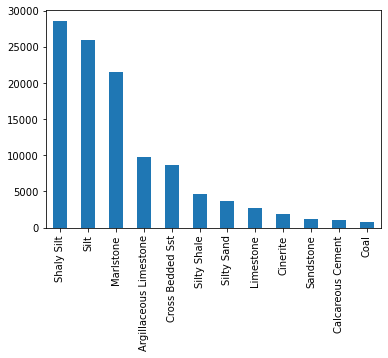

In [14]:
df['LITHOLOGY_GEOLINK'].value_counts().plot.bar()
df['LITHOLOGY_GEOLINK'].value_counts()

In [15]:
# Gvie each well an number, since the model needs numbers
well_index = df['Well'].values
well_int = well_index.rename_categories(range(len(well_index.categories))).astype(int)
df['Well_int']= well_int
df[['Well_int']]

Well_int
Well    DEPT             
30_11-3 2118.70         0
        2118.85         0
        2119.00         0
        2119.15         0
        2119.30         0
...                   ...
30_7-7  5022.10        13
        5022.25        13
        5022.40        13
        5022.55        13
        5022.70        13

[110377 rows x 1 columns]

In [16]:
# Select the N longest well logs
wells = sorted(df['Well'].unique())
n_wells = min(len(wells), max_wells)
selected_wells = wells[:n_wells]
df = df.loc[selected_wells]
# df

In [17]:
# Get a list of wells, ordered by frequency
well_counts = df['Well'].value_counts()
well_counts = well_counts[well_counts>0]
wells = list(well_counts.index)
# well_counts.plot.bar()
1
# well_counts

1

In [18]:
# We want to see the facies N intervals above
df['LITH_ABV'] = df["LITHOLOGY_GEOLINK"].shift(shift_length).fillna('Shaly Silt')
df['LITH_ABV_INT'] = df['LITH_ABV'].values.codes
df[['LITHOLOGY_GEOLINK', 'LITH_ABV']]

LITHOLOGY_GEOLINK          LITH_ABV
Well    DEPT                                       
30_11-3 2118.70              Silt        Shaly Silt
        2118.85              Silt        Shaly Silt
        2119.00              Silt        Shaly Silt
        2119.15              Silt        Shaly Silt
        2119.30              Silt        Shaly Silt
...                           ...               ...
30_7-7  5022.10              Silt              Silt
        5022.25              Silt              Silt
        5022.40              Silt              Silt
        5022.55              Silt  Cross Bedded Sst
        5022.70              Silt  Cross Bedded Sst

[110377 rows x 2 columns]

### Split data

There are many ways to split the data, the best way would be to split by well, but this is too hard and leads to poor results.

We could split randomly but this is too easy, since seeing the lithology at 1000 m gives you 90% of the answer at 1010 m.

Lets split the wells by depth, this way the model gets some idea about each well, but can't peek ahead. We will take the top of the well as training for even numbered wells, and vice versa. There is a graph below showing the outcome.


In [19]:

from functools import partial

def get_depth_thresh(x, even_bottom=True):
    """
    On even number well codes take the bottom of the well for trainin
    """
    if len(x)==0: return x
    
    # if the well code is even take the top 
    code_is_even = (x['Well'].values.codes[0]%2)==0
    if code_is_even:
        even_bottom = not even_bottom
    
    d = x['DEPT']
    thresh = np.round(d.mean())
    x['thresh'] = thresh
    if even_bottom:
        return x[d<thresh]
    else:
        return x[d>thresh]


df_test = df.groupby(level=0).apply(partial(get_depth_thresh, even_bottom=False))
df_train = df.groupby(level=0).apply(partial(get_depth_thresh, even_bottom=True))
print('train', df_train.shape, 'test', df_test.shape)
print(f'Train {len(df_train)/len(df):.0%}, test {len(df_test)/len(df):.0%}')

train (54647, 25) test (55730, 25)
Train 50%, test 50%


In [20]:
train = []
test = []
for i, well in enumerate(selected_wells):
    df_well = df.loc[well]
    df_well.name = well
    i_halfway = int(len(df_well)*0.5)
    df_top = df_well.iloc[:i_halfway]
    df_bottom = df_well.iloc[i_halfway:]
    is_even = i%2==0
    if is_even==0:
        train.append(df_top)
        test.append(df_bottom)
    else:
        train.append(df_bottom)
        test.append(df_top)
        
df_test = pd.concat(test).set_index(['Well', 'DEPT'], drop=False)
df_train = pd.concat(train).set_index(['Well', 'DEPT'], drop=False)
print('train', df_train.shape, 'test', df_test.shape)
print(f'Train {len(df_train)/len(df):.0%}, test {len(df_test)/len(df):.0%}')

train (55188, 24) test (55189, 24)
Train 50%, test 50%


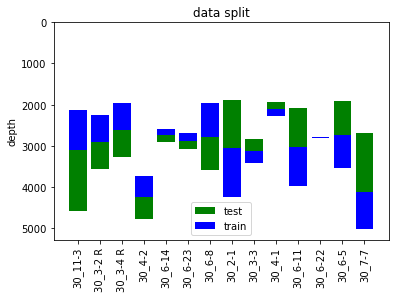

In [21]:
# Plot the data split
well_split = []
for i, well in enumerate(selected_wells):
    df_well = df.loc[well]
    i_halfway = int(len(df_well)*0.5)
    is_even = i%2==0
    well_split.append(dict(
        well=well,
        top=df_well.Depth.min(),
        half=df_well.Depth.iloc[i_halfway],
        bottom=df_well.Depth.max(),
        train_top=is_even,
    ))
    
df_well_split = pd.DataFrame(well_split)

well_top = df_well_split[df_well_split.train_top]
well_bottom = df_well_split[~df_well_split.train_top]

# Do the ones where train is at top
plt.bar(
    x=well_top.well,
    height=well_top.bottom,
    color="green",
    label="test"
)
plt.bar(
    x=well_top.well,
    height=well_top.half,
    color="blue",
    label="train"
)
plt.bar(
    x=well_top.well,
    height=well_top.top,
    color="white",
)


# Others
plt.bar(
    x=well_bottom.well,
    height=well_bottom.bottom,
    color="blue",
)
plt.bar(
    x=well_bottom.well,
    height=well_bottom.half,
    color="green",
)
plt.bar(
    x=well_bottom.well,
    height=well_bottom.top,
    color="white",
)
plt.gca().invert_yaxis()

plt.legend()
plt.title('data split')
plt.xticks(rotation=90)
plt.ylabel('depth')
plt.show()

In [22]:
# Double check there is not overlap
a=set(df_train.index)
b=set(df_test.index)
assert len(a.intersection(b))==0

### Scale

We need to process the input and target data. The input data needs to be normalised with a standard scaler, and the output data needs to be converted from text to numbers. To convert text to numbers we use `LabelEncoder` from Scikit Learn.

In [23]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

scaler = StandardScaler()

# Make a encoder, that order by frequency
encoder = LabelEncoder()

# Instead of fitting, use the same codes as the pandas.Category
encoder.classes_ = df["LITHOLOGY_GEOLINK"].values.categories
print(encoder.classes_)
feat_cols = feature_cols = ['CALI', 'DTC', 'GR', 'RDEP', 'RHOB', 'RMED', 'xc', 'yc', 'DEPT', "LITH_ABV_INT"]
scaler.fit(df[feat_cols].values)

Index(['Coal', 'Calcareous Cement', 'Sandstone', 'Cinerite', 'Limestone',
       'Silty Sand', 'Silty Shale', 'Cross Bedded Sst',
       'Argillaceous Limestone', 'Marlstone', 'Silt', 'Shaly Silt'],
      dtype='object')


StandardScaler()

`LabelEncoder` converts each type to a value.

In [24]:
encoder.transform(["Shaly Silt"])

array([5])

### To pytorch sequences

We will be using depth and other measurements to determine the lithology. We dealt with the same problem in the tablular data. But in tabular data we only look at the measurements at each depth to find the class, while here we can look at the variations in the measurements as well.

In [25]:

def get_sequences(df, seq_length = 10):
    """Take moving sequences of a dataframe"""
    

    x = []
    y = []
    features = scaler.transform(df.loc[:, feat_cols].values)
    targets = encoder.transform(df.loc[:, "LITHOLOGY_GEOLINK"])

    # Add prev labels, as one hot, to inputs
    one_hot_targets = np.eye(len(encoder.classes_))[targets]
    prev_one_host_targets = np.roll(one_hot_targets, shift=shift_length)
    features = np.concatenate([features, prev_one_host_targets], 1)

    for i in range(len(targets) - seq_length):
        xi = features[i : i + seq_length, :]
        yi = targets[i + seq_length - 1]
        x.append(xi)
        y.append(yi)
    return x, y

In [26]:
def to_numpy(x):
    if isinstance(x, torch.Tensor):
        x = x.cpu().detach().numpy()
    return x

In [27]:
x_train, y_train = get_sequences(df_train, seq_length=seq_length)
x_test, y_test = get_sequences(df_test, seq_length=seq_length)

# What's the shape or one row of data? 
print(x_test[0].shape, y_test[0].shape)
x_test[0], y_test[0]

(600, 22) ()


(array([[ 0.18674313,  0.63208858, -0.13193864, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.23247201,  0.266172  , -0.1669922 , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.23922372, -0.11931467, -0.18575272, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.07625717,  0.82926069,  0.23976992, ...,  1.        ,
          0.        ,  0.        ],
        [ 0.07595044,  0.68070465,  0.52922266, ...,  1.        ,
          0.        ,  0.        ],
        [ 0.07564312,  0.65511373,  0.69077122, ...,  1.        ,
          0.        ,  0.        ]]),
 10)

The output of a classification model is a value for each type. The type with the highest value is the one the model thinks is most likely to be associated with the input data. Therefore, the output size of the model should be the number of types.

In [28]:
output_size = len(df["LITHOLOGY_GEOLINK"].unique())

### Distribution

It is important that we make sure the training and test set have close distribution. For instance, if there is a certain type in test data that doesn't exist in training data, the model will not be able to predict it.

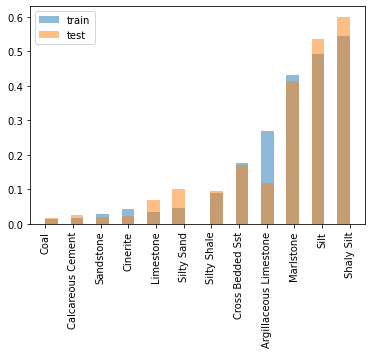

In [29]:
def show_distribution(y, label):
    y = to_numpy(y)
    plt.hist(y, output_size * 2, alpha=0.5, label=label, density=True)
    plt.xticks(ticks=range(len(encoder.classes_)), labels=encoder.classes_, rotation=90)

show_distribution(y_train, 'train')
show_distribution(y_test, 'test')
plt.legend()
plt.show()

## Baseline accuracy

When you experiment with a machine learning problem it's important to use a baseline, to check if the model is actually doing any work. Sometimes you can use humans, or a prior work, but in novel problems we look at a naive answer, then aim to do better.

Below we investigate several methods of naive estimation and try to beat the best.

[more](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html)

In [30]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score
score_fn=accuracy_score

true = np.array(y_test)
for strategy in ["most_frequent", "uniform"]:
    dummy_clf = DummyClassifier(strategy=strategy)
    dummy_clf.fit(x_train, y_train)
    score = dummy_clf.score(x_test, y_test)
    print(f"baseline accuracy={score:2.2%} for {strategy}")

baseline accuracy=27.50% for most_frequent
baseline accuracy=8.29% for uniform


In [31]:
# Prev litho Baseline, this is like a model that says "the same as the last lithology"
pred_baseline = np.roll(true, shift=shift_length)
score_prev_base=score_fn(true, pred_baseline)
print(f'baseline accuracy {score_prev_base:2.2%} for prev {shift_length} facies values or {shift_length*0.15}m above')

baseline accuracy 53.08% for prev 100 facies values or 15.0m above


OK so which baseline do we use? The highest is the one we need to beat

## Train

Note that this can be simplified with libraries like pytorch lightning or fast-ai, but they are not yet approved at many companies. So we do it manually, this also helps you see the details of the training loop.

In [32]:
class NumpyDataset(torch.utils.data.Dataset):
    """Dataset wrapping arrays.
    Each sample will be retrieved by indexing array along the first dimension.
    Arguments:
        *arrays (numpy.array): arrays that have the same size of the first dimension.
    """

    def __init__(self, *arrays):
        self.arrays = arrays

    def __getitem__(self, index):
        return tuple(array[index] for array in self.arrays)

    def __len__(self):
        return len(self.arrays[0])

In [33]:
def train_epoch(x_train, y_train, model, bs=128, max_epoch_iters=128*128):
    model.train()

    training_loss = []
    training_accuracy = []

    # Put data into a loader
    dset_train = NumpyDataset(x_train, y_train)
    load_train = torch.utils.data.dataloader.DataLoader(
        dset_train, 
        batch_size=bs, pin_memory=True,
        shuffle=True,
    )

    for x, y in tqdm(load_train, leave=False, desc='train'):
        # make it a pytorch gpu variable
        x = x.float().to(device)
        y = y.long().to(device)

        
        optimizer.zero_grad()
        preds = model(x) # Make prediction
        loss = loss_func(preds, y) # Measure error/lopss
        
        # Backprop
        loss.backward()
        optimizer.step()

        # Record stats
        training_loss.append(loss.item())
        accuracy = score_fn(
            to_numpy(y), to_numpy(preds).argmax(-1)
        )
        training_accuracy.append(accuracy)

    return [np.mean(training_loss), np.mean(training_accuracy)]

def test_epoch(x_test, y_test, model, bs=512, max_epoch_iters=128*128):
    model.eval()
    preds = []
    true = []

    test_loss = []

    dset_test = NumpyDataset(x_test[:max_epoch_iters//4], y_test[:max_epoch_iters//4])
    load_test = torch.utils.data.dataloader.DataLoader(dset_test, batch_size=bs, pin_memory=True)
    for x, y in tqdm(load_test, leave=False, desc='test'):
        x = x.float().to(device)
        y = y.long().to(device)
        
        pred = model(x)
        loss = loss_func(pred, y)

        preds.append(to_numpy(pred))
        true.append(to_numpy(y))
        test_loss.append(loss.item())

    preds = np.concatenate(preds, 0).argmax(axis=-1)
    true = np.concatenate(true, 0)
    test_accuracy = score_fn(true, preds)
    return preds, true, np.mean(test_loss), test_accuracy

def training_loop(x_train, y_train, x_test, y_test, mode, epochs=1, bs=128, max_epoch_iters=128*128):
    all_losses = []
    all_accuracys = []
    try:
        _, _, test_loss, test_acc = test_epoch(x_test, y_test, model, max_epoch_iters=max_epoch_iters)
        print(
                f"Start: Test Loss = {test_loss:.2f}, Test accuracy = {test_acc:.3f}"
            )
        for epoch in tqdm(range(epochs), desc='epochs'):
            loss, acc = train_epoch(x_train, y_train, model, bs=bs, max_epoch_iters=max_epoch_iters)
            print(f"Epoch {epoch+1}/{epochs}: Training Loss = {loss:.2f}, Train accuracy = {acc:.3f}")
            
            _, _, test_loss, test_acc = test_epoch(x_test, y_test, model, max_epoch_iters=max_epoch_iters)
            print(
                f"Epoch {epoch+1}/{epochs}: Test Loss = {test_loss:.2f}, Test accuracy = {test_acc:.3f}"
            )
            print("-" * 50)
        
            all_losses.append([loss, test_loss])
            all_accuracys.append([acc, test_acc])
            
    except KeyboardInterrupt:
        # This lets you stop manually. and still get the results
        pass

    # Visualising the results
    all_losses = np.array(all_losses)
    plt.plot(all_losses[:, 0], label="Training")
    plt.plot(all_losses[:, 1], label="Test")
    plt.title("Loss")
    plt.legend()
    
    plt.figure()
    all_accuracys = np.array(all_accuracys)
    plt.plot(all_accuracys[:, 0], label="Training")
    plt.plot(all_accuracys[:, 1], label="Test")
    plt.title("accuracy")
    plt.legend()
    
    return all_losses, all_accuracys

In [81]:
# Init the model
model = LSTM(
    input_size=x_train[0].shape[-1],
    hidden_size=32,
    num_layers=2,
    output_size=output_size,
)
model = model.to(device)
model

LSTM(
  (lstm): LSTM(22, 32, num_layers=2, batch_first=True)
  (linear): Linear(in_features=32, out_features=12, bias=True)
)

In [82]:
# Init the optimiser, and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = torch.nn.CrossEntropyLoss().to(device)

Let's train for 10 epochs

Start: Test Loss = 2.46, Test accuracy = 0.028


Epoch 1/4: Training Loss = 0.99, Train accuracy = 0.661


Epoch 1/4: Test Loss = 0.95, Test accuracy = 0.683
--------------------------------------------------


Epoch 2/4: Training Loss = 0.59, Train accuracy = 0.776


Epoch 2/4: Test Loss = 0.78, Test accuracy = 0.778
--------------------------------------------------


Epoch 3/4: Training Loss = 0.50, Train accuracy = 0.809


Epoch 3/4: Test Loss = 0.82, Test accuracy = 0.773
--------------------------------------------------


Epoch 4/4: Training Loss = 0.48, Train accuracy = 0.815


Epoch 4/4: Test Loss = 0.66, Test accuracy = 0.790
--------------------------------------------------



(array([[0.99048853, 0.95117764],
        [0.59272638, 0.78306939],
        [0.49824141, 0.82395127],
        [0.48168926, 0.66136415]]),
 array([[0.66118517, 0.68261719],
        [0.77624199, 0.77783203],
        [0.80896707, 0.77294922],
        [0.81517701, 0.78955078]]))

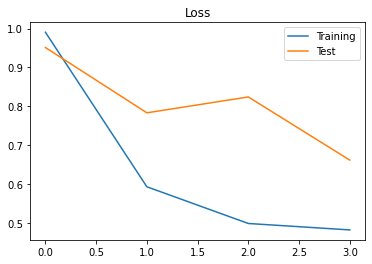

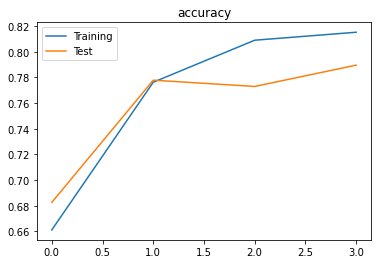

In [83]:
training_loop(x_train, y_train, x_test, y_test, model, epochs=4, bs=128)

Did it overfit?

## Test

In [84]:
preds, true, loss, acc = test_epoch(x_test, y_test, model)
print('final test acc', acc)

final test acc 0.78955078125


### Reports

This beats the baseline, so the model is doing better than the naive answer of "the same again". But lets break it down by lithology

In [85]:
import pandas as pd
import sklearn.metrics
import numpy as np

def classification_report(*args, **kwargs):
    out_df = pd.DataFrame(sklearn.metrics.classification_report(*args, **kwargs, output_dict=True)).T
    # Order cols
    out_df[["precision","recall","f1-score","support"]]  
    # Round
    out_df[["precision","recall","f1-score"]]= out_df[["precision","recall","f1-score"]].apply(lambda x: round(x,2))
    out_df[["support"]]= out_df[["support"]].apply(lambda x: x.astype(np.int))
    return out_df

In [86]:
# pred_baseline = np.roll(true, shift=shift_length)
# df_report = classification_report(true, pred_baseline, labels=range(len(encoder.classes_)), target_names=encoder.classes_)
# df_report[df_report.support>0]

In [87]:
df_report = classification_report(true, preds, labels=range(len(encoder.classes_)), target_names=encoder.classes_)
df_report[df_report.support>0]

/home/wassname/anaconda/envs/deep_ml_curriculum/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/wassname/anaconda/envs/deep_ml_curriculum/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
Calcareous Cement,0.00,0.00,0.00,3
Cinerite,0.81,0.79,0.80,110
Limestone,0.91,0.95,0.93,599
Silty Sand,0.99,0.53,0.69,616
Argillaceous Limestone,0.55,0.25,0.35,237
Marlstone,0.70,0.93,0.80,445
Silt,0.78,0.95,0.86,1833
Shaly Silt,0.36,0.13,0.19,253
micro avg,0.79,0.79,0.79,4096
macro avg,0.42,0.38,0.38,4096


In [88]:
def confusion_matrix(true, preds):
    cm = sklearn.metrics.confusion_matrix(true, preds, labels=range(len(encoder.classes_)))

    plt.figure(figsize=(10, 10))
    plt.title('Confusion Matrix')
    ax=plt.gca()
    disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=encoder.classes_)
    disp.plot(ax=ax, xticks_rotation=90)
    plt.show()

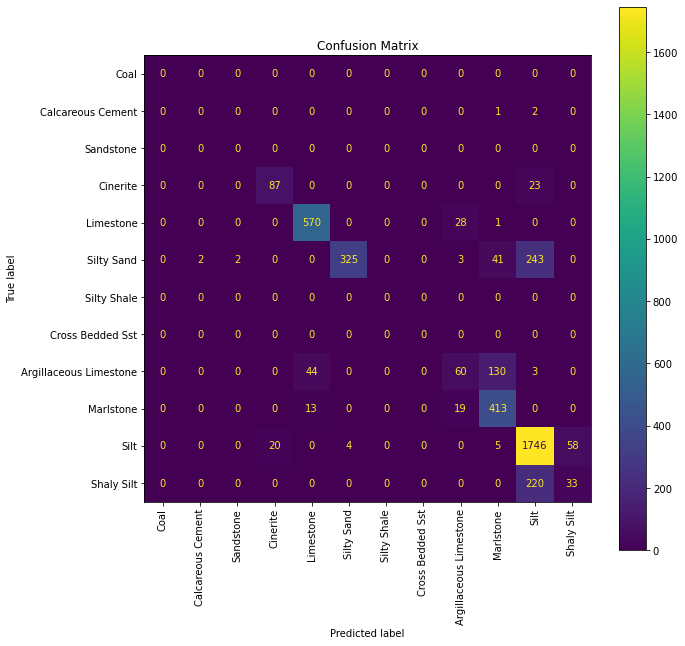

In [89]:
confusion_matrix(true, preds)

## Plot results

Let's have a look at model's predictions.

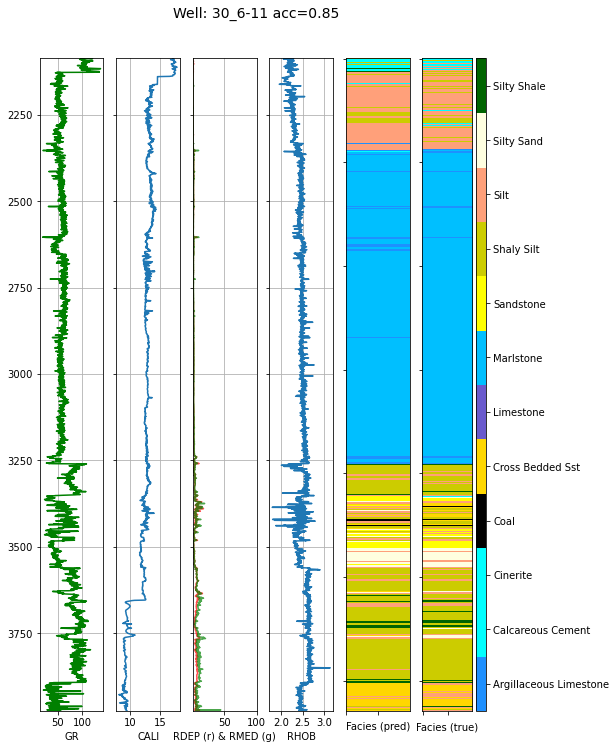

,LITHOLOGY_GEOLINK,pred
DEPT,,
2087.20,Silt,Shaly Silt
2087.35,Silt,Shaly Silt
2087.50,Shaly Silt,Shaly Silt
2087.65,Shaly Silt,Silty Shale
2087.80,Shaly Silt,Silty Shale
...,...,...
3974.20,Silt,Cross Bedded Sst
3974.35,Silt,Cross Bedded Sst
3974.50,Silt,Cross Bedded Sst


In [90]:
from deep_ml_curriculum.visualization.well_log import plot_well_pred

def plot_well(df, model, depth_min=0, depth_max=18000, well_name="30_6-11", device=device):
    logs = df.loc[well_name].sort_index()
    x_test, y_test = get_sequences(logs)
    x_test = torch.Tensor(x_test)
    preds = to_numpy(model(x_test.to(device)).argmax(axis=-1))
    acc = score_fn(y_test, preds)
    df_log_results = logs.iloc[10:].copy()
    df_log_results['pred'] = pd.Categorical(encoder.inverse_transform(preds), categories=df_log_results.LITHOLOGY_GEOLINK.values.categories)
    
    # Lets zoom in on an interesting interval a:b
    plot_well_pred(f'{well_name} acc={acc:2.2f}', df_log_results.loc[depth_min:depth_max],
                   facies_true=df_log_results.loc[depth_min:depth_max].LITHOLOGY_GEOLINK.values, 
                   facies_pred=df_log_results.loc[depth_min:depth_max].pred.values)
    plt.show()
    return df_log_results[['LITHOLOGY_GEOLINK', 'pred']]
    
plot_well(df, model)

In [91]:
print(f'{n_wells} wells. {max_lithologies} lithologies')
print(f'context length of {0.15*seq_length} m or {seq_length} intervals')
print(f'model can see human labels up to {shift_length*0.15}m above. Or {shift_length} intervals')
print(f'baseline accuracy {score_prev_base:2.2%} for prev {shift_length} facies values')

14 wells. 12 lithologies
context length of 60.0 m or 400 intervals
model can see human labels up to 15.0m above. Or 100 intervals
baseline accuracy 52.94% for prev 100 facies values


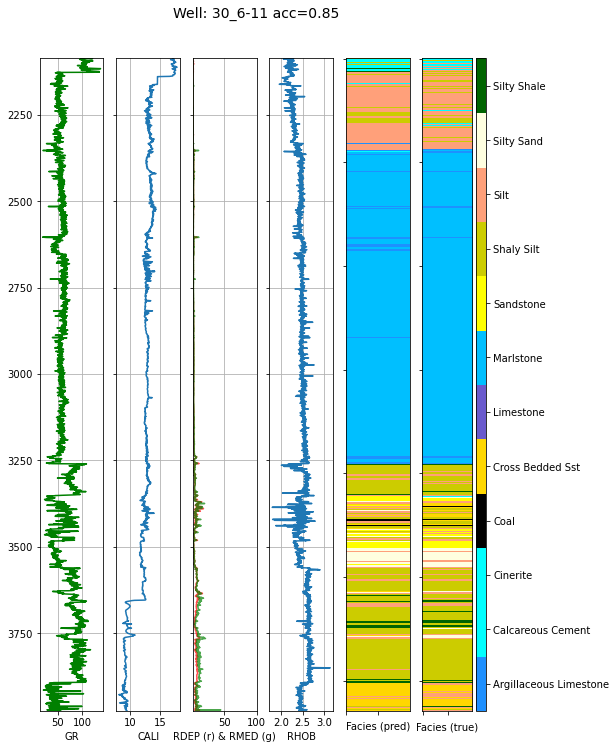

,LITHOLOGY_GEOLINK,pred
DEPT,,
2087.20,Silt,Shaly Silt
2087.35,Silt,Shaly Silt
2087.50,Shaly Silt,Shaly Silt
2087.65,Shaly Silt,Silty Shale
2087.80,Shaly Silt,Silty Shale
...,...,...
3974.20,Silt,Cross Bedded Sst
3974.35,Silt,Cross Bedded Sst
3974.50,Silt,Cross Bedded Sst


In [92]:
# The bottom half was test
plot_well(df, model)#, depth_min=3000, depth_max=6000)

The model requires hyper parameter tuning and possibly training over 100s of epochs to reach the best results. However, in this example due to large size of dataset and the model we stopped after `10` epochs. 

There are number ways we can improve it:

- Training for longer. Instead of stopping after 10 `epochs` go for longer. (might overfit)
- Increase or decrease the `hidden_size`. (might overfit)
- Increase the size of the sequences `seq_length` so the model get to look further in the history. (might underfit)
- Increase the learning rate or decrease batch size `bs` (might overfit)
- (advanced) Increase the size of training data by adding data from more wells to training. `max_wells` (might underfit)

#### Exercise 2

Try one of the options above to improve the model. (hint search for "# CHANGE ME",  change values, then rerun notebook)

<div class="alert alert-success">
  <h2>Exercise</h2>

  Try one of the options above to improve the model. 
    
  To help we've collected and summarised all the code below, so you can change and run the cells below
    
    
  ```python
# Params
seq_length = 400  # CHANGE ME

# Prepare data
x_train, y_train = get_sequences(df_train, seq_length=seq_length)
x_test, y_test = get_sequences(df_test, seq_length=seq_length)

# Init the model
model = LSTM(
    input_size=x_train[0].shape[-1],
    hidden_size=64, # CHANGE ME
    num_layers=3, # CHANGE ME
    output_size=output_size,
).to(device)

# Init the optimiser, and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001) # CHANGE ME
loss_func = torch.nn.CrossEntropyLoss().to(device)

# Train
training_loop(x_train, y_train, x_test, y_test, model, epochs=10, bs=128) # Change me

# Measure baseline
pred_baseline = np.roll(np.array(y_test), shift=shift_length)
score_prev_base=score_fn(y_test, pred_baseline)
print(f'baseline accuracy {score_prev_base:2.2%} for prev {shift_length} facies values')
print(f'{n_wells} wells. {max_lithologies} lithologies')
print(f'context length of {0.15*seq_length} m or {seq_length} intervals')
print(f'model can see human labels up to {shift_length*0.15}m above. Or {shift_length} intervals')
print(f'baseline accuracy {score_prev_base:2.2%} for prev {shift_length} facies values')

# Test
preds, true, loss, acc = test_epoch(x_test, y_test, model)
print('acc', acc)

df_report = classification_report(true, preds, labels=range(len(encoder.classes_)), target_names=encoder.classes_)
display(df_report[df_report.support>0])

plot_well(df, model)
confusion_matrix(true, preds)
1
  ```

  <details>
  <summary><b>→ Hints</b></summary>
      
  - The model is close to over fitting to just increasing epochs, or hidden size likely wont help

  - To change a value
      - Hint search for "# CHANGE ME" below
      - Change values
      - then run the cells
      - wait, some values will take longer

  </details>

  <br/>
  <br/>
  <details>
  <summary>
    <b>→ Solution</b>
  </summary>

  ```python
  # this helps a lot
  seq_length = 1000 
  ```

  </details>

  </div>

In [ ]:
# Params
seq_length = 400  # CHANGE ME

# Prepare data
x_train, y_train = get_sequences(df_train, seq_length=seq_length)
x_test, y_test = get_sequences(df_test, seq_length=seq_length)

# Init the model
model = LSTM(
    input_size=x_train[0].shape[-1],
    hidden_size=64, # CHANGE ME
    num_layers=3, # CHANGE ME
    output_size=output_size,
).to(device)

# Init the optimiser, and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001) # CHANGE ME
loss_func = torch.nn.CrossEntropyLoss().to(device)

# Train
training_loop(x_train, y_train, x_test, y_test, model, epochs=10, bs=128) # Change me

# Measure baseline
pred_baseline = np.roll(np.array(y_test), shift=shift_length)
score_prev_base=score_fn(y_test, pred_baseline)
print(f'baseline accuracy {score_prev_base:2.2%} for prev {shift_length} facies values')
print(f'{n_wells} wells. {max_lithologies} lithologies')
print(f'context length of {0.15*seq_length} m or {seq_length} intervals')
print(f'model can see human labels up to {shift_length*0.15}m above. Or {shift_length} intervals')
print(f'baseline accuracy {score_prev_base:2.2%} for prev {shift_length} facies values')

# Test
preds, true, loss, acc = test_epoch(x_test, y_test, model)
print('final test acc', acc)

df_report = classification_report(true, preds, labels=range(len(encoder.classes_)), target_names=encoder.classes_)
display(df_report[df_report.support>0])

plot_well(df, model)
confusion_matrix(true, preds)
1

Start: Test Loss = 2.48, Test accuracy = 0.000


Epoch 1/10: Training Loss = 0.90, Train accuracy = 0.674


Epoch 1/10: Test Loss = 1.12, Test accuracy = 0.677
--------------------------------------------------


In [ ]:
# Params
seq_length = 400  # CHANGE ME

# Prepare data
x_train, y_train = get_sequences(df_train, seq_length=seq_length)
x_test, y_test = get_sequences(df_test, seq_length=seq_length)

# Init the model
model = LSTM(
    input_size=x_train[0].shape[-1],
    hidden_size=64, # CHANGE ME
    num_layers=3, # CHANGE ME
    output_size=output_size,
).to(device)

# Init the optimiser, and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001) # CHANGE ME

counts = pd.Series(y_train).value_counts().sort_index() + 1000
weights = 1/counts.values
weights /= weights.sum()
loss_func = torch.nn.CrossEntropyLoss(weight=torch.from_numpy(weights).float()).to(device)

plt.title('label weighting')
plt.bar(range(weights.shape[0]), weights)
plt.show()

# Train
training_loop(x_train, y_train, x_test, y_test, model, epochs=10, bs=128) # Change me

# Measure baseline
pred_baseline = np.roll(np.array(y_test), shift=shift_length)
score_prev_base=score_fn(y_test, pred_baseline)
print(f'baseline accuracy {score_prev_base:2.2%} for prev {shift_length} facies values')
print(f'{n_wells} wells. {max_lithologies} lithologies')
print(f'context length of {0.15*seq_length} m or {seq_length} intervals')
print(f'model can see human labels up to {shift_length*0.15}m above. Or {shift_length} intervals')
print(f'baseline accuracy {score_prev_base:2.2%} for prev {shift_length} facies values')

# Test
preds, true, loss, acc = test_epoch(x_test, y_test, model)
print('final test acc', acc)

df_report = classification_report(true, preds, labels=range(len(encoder.classes_)), target_names=encoder.classes_)
display(df_report[df_report.support>0])

plot_well(df, model)
confusion_matrix(true, preds)
1

## Further Reading
- [Introduction to RNN](http://slazebni.cs.illinois.edu/spring17/lec02_rnn.pdf)
- [A friendly introduction to Recurrent Neural Networks](https://www.youtube.com/watch?v=UNmqTiOnRfg)
- [Recurrent Neural Networks (RNN) and Long Short-Term Memory (LSTM)](https://www.youtube.com/watch?v=WCUNPb-5EYI&t=97s)
- [Introduction to LSTM](https://medium.com/x8-the-ai-community/a-7-minute-introduction-to-lstm-5e1480e6f52a)
- [LSTM and GRU](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)
- [Time Series Prediction with LSTM](https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/)
- [Building RNN from scratch](https://medium.com/dair-ai/building-rnns-is-fun-with-pytorch-and-google-colab-3903ea9a3a79)
